# Петрик і Вовк: Вступ до навчання з підкріпленням

У цьому навчальному посібнику ми навчимося застосовувати навчання з підкріпленням до задачі пошуку шляху. Сюжет натхненний музичною казкою [Петрик і Вовк](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) російського композитора [Сергія Прокоф'єва](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Це історія про юного піонера Петрика, який сміливо виходить з дому на лісову галявину, щоб переслідувати вовка. Ми будемо тренувати алгоритми машинного навчання, які допоможуть Петрику досліджувати навколишню місцевість і створити оптимальну карту навігації.

Спершу імпортуємо кілька корисних бібліотек:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Огляд навчання з підкріпленням

**Навчання з підкріпленням** (RL) — це техніка навчання, яка дозволяє нам вивчати оптимальну поведінку **агента** в певному **середовищі**, проводячи багато експериментів. Агент у цьому середовищі повинен мати певну **мету**, визначену за допомогою **функції винагороди**.

## Середовище

Для простоти розглянемо світ Пітера як квадратну дошку розміром `width` x `height`. Кожна клітинка на цій дошці може бути:
* **землею**, по якій Пітер та інші створіння можуть ходити
* **водою**, по якій, очевидно, ходити неможливо
* **деревом** або **травою** — місцем, де можна трохи відпочити
* **яблуком**, яке символізує щось, що Пітер буде радий знайти, щоб нагодувати себе
* **вовком**, який є небезпечним і якого слід уникати

Для роботи із середовищем ми визначимо клас під назвою `Board`. Щоб не перевантажувати цей блокнот зайвим кодом, ми перенесли весь код для роботи з дошкою в окремий модуль `rlboard`, який зараз імпортуємо. Ви можете заглянути всередину цього модуля, щоб отримати більше деталей про внутрішню реалізацію.


In [2]:
from rlboard import *

Давайте тепер створимо випадкову дошку і подивимося, як вона виглядає:


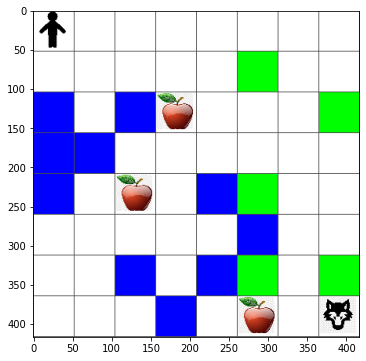

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Дії та Політика

У нашому прикладі мета Пітера — знайти яблуко, уникаючи вовка та інших перешкод. Для цього він може просто ходити, поки не знайде яблуко. Таким чином, у будь-якій позиції він може обрати одну з наступних дій: вгору, вниз, вліво або вправо. Ми визначимо ці дії як словник і зіставимо їх із парами відповідних змін координат. Наприклад, рух вправо (`R`) відповідатиме парі `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Стратегія нашого агента (Пітера) визначається так званою **політикою**. Розглянемо найпростішу політику, яка називається **випадкове блукання**.

## Випадкове блукання

Спочатку вирішимо нашу задачу, реалізувавши стратегію випадкового блукання.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Давайте проведемо експеримент випадкової прогулянки кілька разів і подивимось середню кількість зроблених кроків:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Функція винагороди

Щоб зробити нашу політику більш розумною, нам потрібно зрозуміти, які ходи є "кращими" за інші.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Створіть Q-таблицю або багатовимірний масив. Оскільки наша дошка має розміри `width` x `height`, ми можемо представити Q-таблицю за допомогою numpy-масиву з формою `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Передайте Q-таблицю до функції побудови графіка, щоб візуалізувати таблицю на дошці:


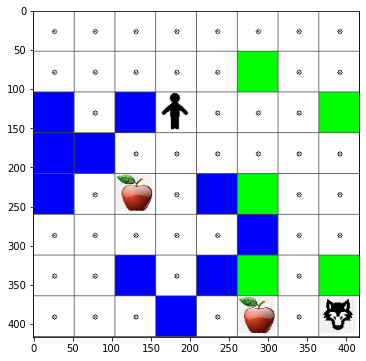

In [9]:
m.plot(Q)

## Суть Q-навчання: Рівняння Беллмана та алгоритм навчання

Напишіть псевдокод для нашого алгоритму навчання:

* Ініціалізуйте Q-таблицю Q однаковими значеннями для всіх станів і дій
* Встановіть швидкість навчання $\alpha\leftarrow 1$
* Повторюйте симуляцію багато разів
   1. Почніть з випадкової позиції
   1. Повторюйте
        1. Оберіть дію $a$ у стані $s$
        2. Виконайте дію, перейшовши до нового стану $s'$
        3. Якщо досягнуто кінцевої умови гри або загальна винагорода занадто мала — вийдіть із симуляції  
        4. Обчисліть винагороду $r$ у новому стані
        5. Оновіть Q-функцію згідно з рівнянням Беллмана: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Оновіть загальну винагороду та зменшіть $\alpha$.

## Експлуатація проти дослідження

Найкращий підхід — це баланс між дослідженням і експлуатацією. У міру того, як ми більше дізнаємося про наше середовище, ми будемо частіше слідувати оптимальному маршруту, однак іноді варто обирати невивчений шлях.

## Реалізація на Python

Тепер ми готові реалізувати алгоритм навчання. Перед цим нам також потрібна функція, яка перетворить довільні числа в Q-таблиці на вектор ймовірностей для відповідних дій:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Ми додаємо невелику кількість `eps` до початкового вектора, щоб уникнути ділення на 0 у початковому випадку, коли всі компоненти вектора однакові.

Фактичний алгоритм навчання ми будемо запускати протягом 5000 експериментів, які також називаються **епохами**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Після виконання цього алгоритму таблиця Q повинна бути оновлена значеннями, які визначають привабливість різних дій на кожному кроці. Візуалізуйте таблицю тут:


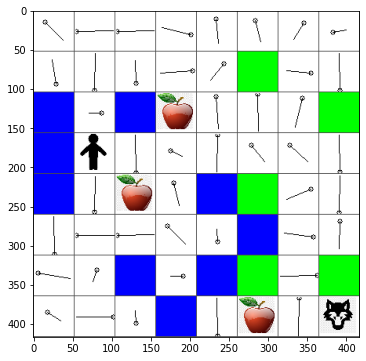

In [12]:
m.plot(Q)

## Перевірка політики

Оскільки Q-таблиця відображає "привабливість" кожної дії в кожному стані, її досить легко використовувати для визначення ефективного маршруту в нашому світі. У найпростішому випадку ми можемо просто обрати дію, яка відповідає найвищому значенню в Q-таблиці:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Якщо ви спробуєте код вище кілька разів, ви можете помітити, що іноді він просто "зависає", і вам потрібно натиснути кнопку STOP у блокноті, щоб перервати його.

> **Завдання 1:** Змініть функцію `walk`, щоб обмежити максимальну довжину шляху певною кількістю кроків (наприклад, 100), і спостерігайте, як код вище час від часу повертає це значення.

> **Завдання 2:** Змініть функцію `walk`, щоб вона не поверталася до місць, де вже була раніше. Це запобігатиме зацикленню `walk`, однак агент все одно може опинитися "застряглим" у місці, з якого він не може вибратися.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


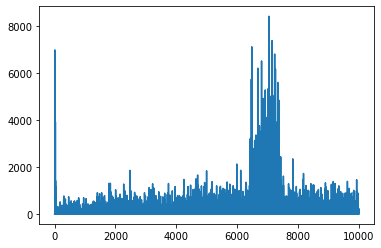

In [15]:
plt.plot(lpath)

Те, що ми бачимо тут, — це те, що спочатку середня довжина шляху збільшилася. Це, ймовірно, пов’язано з тим, що коли ми нічого не знаємо про середовище, ми, швидше за все, потрапляємо в погані стани, воду або до вовка. Коли ми дізнаємося більше і починаємо використовувати ці знання, ми можемо досліджувати середовище довше, але все ще недостатньо добре знаємо, де знаходяться яблука.

Коли ми дізнаємося достатньо, агенту стає легше досягти мети, і довжина шляху починає зменшуватися. Однак ми все ще відкриті до досліджень, тому часто відхиляємося від найкращого шляху і досліджуємо нові варіанти, що робить шлях довшим за оптимальний.

Що ми також спостерігаємо на цьому графіку, так це те, що в певний момент довжина різко збільшилася. Це вказує на стохастичну природу процесу і на те, що ми можемо в певний момент "зіпсувати" коефіцієнти Q-таблиці, перезаписавши їх новими значеннями. Це бажано мінімізувати шляхом зменшення швидкості навчання (тобто ближче до завершення тренування ми лише незначно коригуємо значення Q-таблиці).

Загалом важливо пам’ятати, що успіх і якість процесу навчання значною мірою залежать від параметрів, таких як швидкість навчання, зменшення швидкості навчання та коефіцієнт дисконтування. Їх часто називають **гіперпараметрами**, щоб відрізнити їх від **параметрів**, які ми оптимізуємо під час тренування (наприклад, коефіцієнти Q-таблиці). Процес пошуку найкращих значень гіперпараметрів називається **оптимізацією гіперпараметрів**, і він заслуговує на окрему тему.


## Вправа
#### Більш реалістичний світ "Петрик і вовк"

У нашій ситуації Петрик міг пересуватися майже без втоми чи голоду. У більш реалістичному світі йому доводиться час від часу сідати і відпочивати, а також харчуватися. Давайте зробимо наш світ більш реалістичним, впровадивши наступні правила:

1. Пересуваючись з одного місця в інше, Петрик втрачає **енергію** і набирає **втому**.
2. Петрик може отримати більше енергії, з'ївши яблука.
3. Петрик може позбутися втоми, відпочиваючи під деревом або на траві (тобто заходячи на клітинку дошки з деревом або травою - зелене поле).
4. Петрик має знайти і вбити вовка.
5. Для того щоб вбити вовка, Петрик повинен мати певний рівень енергії та втоми, інакше він програє битву.

Модифікуйте функцію винагороди відповідно до правил гри, запустіть алгоритм навчання з підкріпленням, щоб навчитися найкращій стратегії для перемоги в грі, і порівняйте результати випадкових ходів з вашим алгоритмом за кількістю виграних і програних ігор.

> **Примітка**: Можливо, вам доведеться налаштувати гіперпараметри, щоб це працювало, особливо кількість епох. Оскільки успіх у грі (битва з вовком) є рідкісною подією, можна очікувати значно довший час навчання.



---

**Відмова від відповідальності**:  
Цей документ було перекладено за допомогою сервісу автоматичного перекладу [Co-op Translator](https://github.com/Azure/co-op-translator). Хоча ми прагнемо до точності, зверніть увагу, що автоматичні переклади можуть містити помилки або неточності. Оригінальний документ мовою оригіналу слід вважати авторитетним джерелом. Для критично важливої інформації рекомендується професійний людський переклад. Ми не несемо відповідальності за будь-які непорозуміння або неправильні тлумачення, що виникли внаслідок використання цього перекладу.
